In [ ]:
!sudo apt-get install -y python-numpy python-dev cmake zlib1g-dev libjpeg-dev xvfb \
    xorg-dev python-opengl libboost-all-dev libsdl2-dev swig
!pip install pyvirtualdisplay
!pip install piglet

## gym
!pip install gymnasium[classic_control]

##ffmpeg
!sudo apt-get install ffmpeg -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package python-dev is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source
However the following packages replace it:
  python2-dev python2 python-dev-is-python3

E: Unable to locate package python-numpy
E: Package 'python-dev' has no installation candidate
E: Unable to locate package python-opengl
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.


In [ ]:
!sudo apt-get install xvfb
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()
from base64 import b64encode
from glob import glob
from IPython.display import HTML
from IPython import display as ipy_display
from gym import logger as gym_logger
from gym.wrappers.record_video import RecordVideo

#### show video func
def show_video(mode='train', filename=None):
    mp4_list = glob(mode+'/*.mp4')
    # print(mp4_list)
    if mp4_list:
        if filename :
            file_lists = glob(mode+'/'+filename)
            if not file_lists:
                print('No {} found'.format(filename))
                return -1
            mp4 = file_lists[0]

        else:
            mp4 = sorted(mp4_list)[-1]

        print(mp4)
        video = open(mp4, 'r+b').read()
        encoded = b64encode(video)
        ipy_display.display(HTML(data='''
            <video alt="gameplay" autoplay controls style="height: 400px;">
                <source src="data:video/mp4;base64,%s" type="video/mp4" />
            </video>
        ''' % (encoded.decode('ascii'))))
    else:
        print('No video found')
        return -1

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.2).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import gym
import random

import tensorflow as tf
from tensorflow import keras
from keras.utils import plot_model

import warnings
warnings.filterwarnings(action='ignore')

from collections import deque


/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/dtypes.py:35: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  from tensorflow.tsl.python.lib.core import pywrap_ml_dtypes


In [ ]:

class AgentDDPG():
    def __init__(self, state_size, action_size, max_action):
        # 상태 및 행동 크기 정의
        self.state_size = state_size
        self.action_size = action_size
        self.action_bound = max_action
        self.TAU = 0.01
        self.gamma = 0.7    # reward discount 클수록 근시안적이 됨 적당히 크게 설정 영향 많이 받음
        self.batch_size = 25 #클수록 stable / 작을수록 학습 빠름


        # 버퍼 규모, 시작 규모 정의
        self.buffer_size = 10000
        self.buffer = deque(maxlen=self.buffer_size)

        self.buffer_begin = 1000



        ## NN Network
        self.actor = self.actor_network()
        self.target_actor = self.actor_network()

        self.critic = self.critic_network()
        self.target_critic = self.critic_network()

        self.actor_learning_rate = 0.0002
        self.critic_learning_rate = 0.002


        self.actor_opt =  keras.optimizers.Adam(learning_rate = self.actor_learning_rate, clipnorm=5.0)
        self.critic_opt =  keras.optimizers.Adam(learning_rate = self.critic_learning_rate, clipnorm=5.0)


        # save the results
        self.save_epi_score = []

    ## actor
    def actor_network(self):
        input_state = keras.layers.Input(shape=(self.state_size,))

        x = keras.layers.Dense(24, activation='relu')(input_state)
        x = keras.layers.Dense(64, activation='elu', kernel_initializer=keras.initializers.RandomUniform(-1e-3, 1e-3))(x)
        x = keras.layers.Dense(16, activation='tanh', kernel_initializer=keras.initializers.RandomUniform(-1e-3, 1e-3))(x)
        raw_action = keras.layers.Dense(self.action_size, kernel_initializer=keras.initializers.RandomUniform(-1e-3, 1e-3))(x)
        scaled_action = keras.layers.Lambda(lambda a: a * self.action_bound)(raw_action)

        # Define the actor model
        actor_model = keras.models.Model(inputs=[input_state], outputs=[scaled_action])

        return actor_model

    ## critic
    def critic_network(self,):
        input_state = keras.layers.Input(shape=(self.state_size))
        input_action = keras.layers.Input(shape=(self.action_size))

        state = keras.layers.Dense(32, activation='relu')(input_state)
        action = keras.layers.Dense(32, activation='relu')(input_action)

        h = keras.layers.concatenate([state, action], axis=-1)
        x = keras.layers.Dense(32, activation='relu')(h)
        x = keras.layers.Dense(16, activation='relu')(x)
        q_func = keras.layers.Dense(1, activation='relu')(x)
        ## model
        model = keras.models.Model(inputs=[input_state, input_action], outputs=[q_func])

        return model


    # 입력받은 상태, 행동, 보상, 다음상태, done flag를 리플레이 버퍼에 축적하는 함수 구현
    def remember(self, state, action, reward, next_state, done):
        item = (state, action, reward, next_state, done)
        self.buffer.append(item)


    ## get action
    def get_action(self,state, pre_noise):
        action = self.actor(tf.convert_to_tensor([state], dtype=tf.float32))
        # print(f'action_raw : {action}')
        action = action.numpy()[0]
        ## noise
        noise = self.ou_noise(pre_noise, dim=self.action_size)
        # clip continuous action to be within action_bound
        action = np.clip(action + noise, -self.action_bound, self.action_bound)

        # print(f'action : {action}')
        return action , noise



      ## Soft update Target network
    def update_target_network(self, TAU):
        theta = self.actor.get_weights()
        target_theta = self.target_actor.get_weights()
        for i in range(len(theta)):
            target_theta[i] = TAU * theta[i] + (1 - TAU) * target_theta[i]
        self.target_actor.set_weights(target_theta)

        phi = self.critic.get_weights()
        target_phi = self.target_critic.get_weights()
        for i in range(len(phi)):
            target_phi[i] = TAU * phi[i] + (1 - TAU) * target_phi[i]
        self.target_critic.set_weights(target_phi)


    ## single gradient update on a single batch data
    def critic_learn(self, states, actions, td_targets):
        with tf.GradientTape() as tape:
            q = self.critic([states, actions], training=True)
            loss = tf.reduce_mean(tf.square(q - td_targets))

        grads = tape.gradient(loss, self.critic.trainable_variables)
        self.critic_opt.apply_gradients(zip(grads, self.critic.trainable_variables))

    ## train the actor network
    def actor_learn(self, states):
        with tf.GradientTape() as tape:
            actions = self.actor(states, training=True)
            critic_q = self.critic([states, actions])
            loss = -tf.reduce_mean(critic_q)

        grads = tape.gradient(loss, self.actor.trainable_variables)
        self.actor_opt.apply_gradients(zip(grads, self.actor.trainable_variables))

    ## Ornstein Uhlenbeck Noise
    def ou_noise(self, x, rho=0.15, mu=0, dt=1e-1, sigma=0.2, dim=1):
        return x + rho*(mu - x)*dt + sigma*np.sqrt(dt)*np.random.normal(size=dim)


    ## computing TD target: y_k = r_k + gamma*Q(x_k+1, u_k+1)
    def td_target(self, rewards, q_values, dones):
        y_k = np.asarray(q_values)
        for i in range(q_values.shape[0]): # number of batch
            if dones[i]:
                y_k[i] = rewards[i]
            else:
                y_k[i] = rewards[i] + self.gamma * q_values[i]
        return y_k

    ## load actor weights
    def load_weights(self, path):
        self.actor.load_weights(f'./{path}/actor/mountain_car.h5')
        self.critic.load_weights(f'./{path}/critic/mountain_car.h5')


    ## train
    def train_model(self):
        ### replay memory 에서 random하게 minibatch 만큼 샘플을 가져옴
        mini_batch = random.sample(self.buffer, self.batch_size)
        # mini_batch에서 각 아래 정보로 분리하기
        states, actions, rewards, next_states, dones = zip(*mini_batch)

        # 분리된 정보를 tensor 형태로 변환
        states = tf.convert_to_tensor(states)
        actions = tf.convert_to_tensor(actions)
        rewards = tf.convert_to_tensor(rewards)
        next_states = tf.convert_to_tensor(next_states)
        # dones를 True False로 바꿀 껀데 tf.float32 실수 형태로 바꿔 주는코드 (1.0 , 0.0)
        dones = tf.convert_to_tensor(dones, dtype=tf.float32)


        # predict target Q-values
        target_qs = self.target_critic([
                                        next_states,   ## next_state (s_prime)
                                        self.target_actor(next_states) ## next_action (a_prime)
                                      ])

        # compute TD targets
        y_i = self.td_target(rewards, target_qs.numpy(), dones)

        # train critic using sampled batch
        self.critic_learn(states ,   ### state (s)
                          actions,   ### action (a)
                          y_i )      ## TD target: y_k = r_k + gamma*Q(x_k+1, u_k+1)

        # train actor
        self.actor_learn(states)

        # update both target network
        self.update_target_network(self.TAU)

In [53]:

class AgentDDPG2():
    def __init__(self, state_size, action_size, max_action):
        # 상태 및 행동 크기 정의
        self.state_size = state_size
        self.action_size = action_size
        self.action_bound = max_action
        self.TAU = 0.05
        self.gamma = 0.7    # reward discount 클수록 근시안적이 됨 적당히 크게 설정 영향 많이 받음
        self.batch_size = 35 #클수록 stable / 작을수록 학습 빠름


        # 버퍼 규모, 시작 규모 정의
        self.buffer_size = 15000
        self.buffer = deque(maxlen=self.buffer_size)

        self.buffer_begin = 2000



        ## NN Network
        self.actor = self.actor_network()
        self.target_actor = self.actor_network()

        self.critic = self.critic_network()
        self.target_critic = self.critic_network()

        self.actor_learning_rate = 0.0002
        self.critic_learning_rate = 0.002


        self.actor_opt =  keras.optimizers.Adam(learning_rate = self.actor_learning_rate, clipnorm=5.0)
        self.critic_opt =  keras.optimizers.Adam(learning_rate = self.critic_learning_rate, clipnorm=5.0)


        # save the results
        self.save_epi_score = []

    ## actor
    def actor_network(self):
        input_state = keras.layers.Input(shape=(self.state_size,))

        x = keras.layers.Dense(24, activation='relu')(input_state)
        x = keras.layers.Dense(64, activation='elu', kernel_initializer=keras.initializers.RandomUniform(-1e-3, 1e-3))(x)
        x = keras.layers.Dense(16, activation='tanh', kernel_initializer=keras.initializers.RandomUniform(-1e-3, 1e-3))(x)
        raw_action = keras.layers.Dense(self.action_size, kernel_initializer=keras.initializers.RandomUniform(-1e-3, 1e-3))(x)
        scaled_action = keras.layers.Lambda(lambda a: a * self.action_bound)(raw_action)

        # Define the actor model
        actor_model = keras.models.Model(inputs=[input_state], outputs=[scaled_action])

        return actor_model

    ## critic
    def critic_network(self,):
        input_state = keras.layers.Input(shape=(self.state_size))
        input_action = keras.layers.Input(shape=(self.action_size))

        state = keras.layers.Dense(32, activation='relu')(input_state)
        action = keras.layers.Dense(32, activation='relu')(input_action)

        h = keras.layers.concatenate([state, action], axis=-1)
        x = keras.layers.Dense(32, activation='relu')(h)
        x = keras.layers.Dense(16, activation='relu')(x)
        q_func = keras.layers.Dense(1, activation='relu')(x)
        ## model
        model = keras.models.Model(inputs=[input_state, input_action], outputs=[q_func])

        return model


    # 입력받은 상태, 행동, 보상, 다음상태, done flag를 리플레이 버퍼에 축적하는 함수 구현
    def remember(self, state, action, reward, next_state, done):
        item = (state, action, reward, next_state, done)
        self.buffer.append(item)


    ## get action
    def get_action(self,state, pre_noise):
        action = self.actor(tf.convert_to_tensor([state], dtype=tf.float32))
        # print(f'action_raw : {action}')
        action = action.numpy()[0]
        ## noise
        noise = self.ou_noise(pre_noise, dim=self.action_size)
        # clip continuous action to be within action_bound
        action = np.clip(action + noise, -self.action_bound, self.action_bound)

        # print(f'action : {action}')
        return action , noise



      ## Soft update Target network
    def update_target_network(self, TAU):
        theta = self.actor.get_weights()
        target_theta = self.target_actor.get_weights()
        for i in range(len(theta)):
            target_theta[i] = TAU * theta[i] + (1 - TAU) * target_theta[i]
        self.target_actor.set_weights(target_theta)

        phi = self.critic.get_weights()
        target_phi = self.target_critic.get_weights()
        for i in range(len(phi)):
            target_phi[i] = TAU * phi[i] + (1 - TAU) * target_phi[i]
        self.target_critic.set_weights(target_phi)


    ## single gradient update on a single batch data
    def critic_learn(self, states, actions, td_targets):
        with tf.GradientTape() as tape:
            q = self.critic([states, actions], training=True)
            loss = tf.reduce_mean(tf.square(q - td_targets))

        grads = tape.gradient(loss, self.critic.trainable_variables)
        self.critic_opt.apply_gradients(zip(grads, self.critic.trainable_variables))

    ## train the actor network
    def actor_learn(self, states):
        with tf.GradientTape() as tape:
            actions = self.actor(states, training=True)
            critic_q = self.critic([states, actions])
            loss = -tf.reduce_mean(critic_q)

        grads = tape.gradient(loss, self.actor.trainable_variables)
        self.actor_opt.apply_gradients(zip(grads, self.actor.trainable_variables))

    ## Ornstein Uhlenbeck Noise
    def ou_noise(self, x, rho=0.15, mu=0, dt=1e-1, sigma=0.2, dim=1):
        return x + rho*(mu - x)*dt + sigma*np.sqrt(dt)*np.random.normal(size=dim)


    ## computing TD target: y_k = r_k + gamma*Q(x_k+1, u_k+1)
    def td_target(self, rewards, q_values, dones):
        y_k = np.asarray(q_values)
        for i in range(q_values.shape[0]): # number of batch
            if dones[i]:
                y_k[i] = rewards[i]
            else:
                y_k[i] = rewards[i] + self.gamma * q_values[i]
        return y_k

    ## load actor weights
    def load_weights(self, path):
        self.actor.load_weights(f'./{path}/actor/mountain_car.h5')
        self.critic.load_weights(f'./{path}/critic/mountain_car.h5')


    ## train
    def train_model(self):
        ### replay memory 에서 random하게 minibatch 만큼 샘플을 가져옴
        mini_batch = random.sample(self.buffer, self.batch_size)
        # mini_batch에서 각 아래 정보로 분리하기
        states, actions, rewards, next_states, dones = zip(*mini_batch)

        # 분리된 정보를 tensor 형태로 변환
        states = tf.convert_to_tensor(states)
        actions = tf.convert_to_tensor(actions)
        rewards = tf.convert_to_tensor(rewards)
        next_states = tf.convert_to_tensor(next_states)
        # dones를 True False로 바꿀 껀데 tf.float32 실수 형태로 바꿔 주는코드 (1.0 , 0.0)
        dones = tf.convert_to_tensor(dones, dtype=tf.float32)


        # predict target Q-values
        target_qs = self.target_critic([
                                        next_states,   ## next_state (s_prime)
                                        self.target_actor(next_states) ## next_action (a_prime)
                                      ])

        # compute TD targets
        y_i = self.td_target(rewards, target_qs.numpy(), dones)

        # train critic using sampled batch
        self.critic_learn(states ,   ### state (s)
                          actions,   ### action (a)
                          y_i )      ## TD target: y_k = r_k + gamma*Q(x_k+1, u_k+1)

        # train actor
        self.actor_learn(states)

        # update both target network
        self.update_target_network(self.TAU)

Episode: 1, Success: 0, Try: 999, Reward: -13.73, height_max: 0.23
make folder
Episode: 2, Success: 0, Try: 999, Reward: -25.01, height_max: 0.23
Episode: 3, Success: 0, Try: 999, Reward: -10.06, height_max: 0.23
Episode: 4, Success: 0, Try: 999, Reward: -8.51, height_max: 0.23
Episode: 5, Success: 0, Try: 999, Reward: -7.66, height_max: 0.23
Episode: 6, Success: 1, Try: 949, Reward: 77.87, height_max: 0.47
Episode: 7, Success: 1, Try: 999, Reward: -17.11, height_max: 0.47
Episode: 8, Success: 1, Try: 999, Reward: -16.14, height_max: 0.47
Episode: 9, Success: 1, Try: 999, Reward: -13.19, height_max: 0.47
Episode: 10, Success: 2, Try: 989, Reward: 83.30, height_max: 0.47
Episode: 11, Success: 2, Try: 999, Reward: -14.43, height_max: 0.47
Episode: 12, Success: 2, Try: 999, Reward: -17.71, height_max: 0.47
Episode: 13, Success: 2, Try: 999, Reward: -19.90, height_max: 0.47
Episode: 14, Success: 2, Try: 999, Reward: -10.74, height_max: 0.47
Episode: 15, Success: 2, Try: 999, Reward: -8.89,

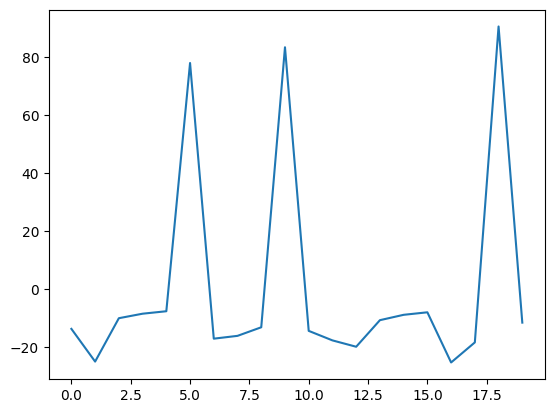

In [43]:
ENV_NAME = 'MountainCarContinuous-v0'
env = gym.make(ENV_NAME)

# 비디오 레코딩
env = RecordVideo(env, './train', episode_trigger =lambda episode_number: True )


# MountainCar 환경의 상태와 행동 크기 정의
state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]
max_action = env.action_space.high[0]


# agent 정의
# gamma, batch size, tau 정의해주기
agent = AgentDDPG(state_size, action_size, max_action)


# 결과 그래프
def result_graph(save_epi_score):
    plt.plot(save_epi_score)
    plt.show()


## default
success = 0
height_max = -0.4

agent.update_target_network(1.0)

num_episode = 20


for ep in range(num_episode):
      # reset episode
    step, time, episode_score, done = 0 ,0, 0, False

    # 초기 noise 설정
    pre_noise = np.zeros(agent.action_size)

    # 환경 reset을 통해 초기 상태 정의
    state = env.reset()

    while not done:
        action , noise = agent.get_action(state, pre_noise) ## actor network로 action 생성 // 다음 step 때 pre_noise를 여기서 생성된 noise로 사용

        # observe reward, new_state
        next_state, reward, done, _ = env.step(action)

        # score
        episode_score += reward


        ## 보상설계
        car_xposition = next_state[0]
        car_vel = next_state[1]

        # reward1 (오래걸릴수록 - & 최대한 많이 움직이도록 velocity절대값)
        reward = float(- step/500 + abs(car_vel)/500)


        # reward2 (차의 x축 기반 높이를 구하는 2차함수 활용)
        # if car_vel > 0:
        #     reward = float(((car_xposition-0.5)*2)**2+15*car_vel - step/300)
        # else:
        #     reward = float(((car_xposition-0.5)*2)**2 - step/300)

        ### max position
        if car_xposition > height_max:
            height_max = car_xposition

        ## 성공 시 success
        if car_xposition >=  0.45:
            reward+=100
            success += 1

        step+=1

        # 플레이 버퍼에 축적
        agent.remember(state, action, reward, next_state, done)
        train_reward= reward


        # buffer 크기가 일정 기준 이상 쌓이면 학습 진행
        if len(agent.buffer) >= agent.buffer_begin :
            agent.train_model()


        # update current state
        pre_noise = noise
        state = next_state
        time += 1

    ## display rewards every episode
    print(f'Episode: {ep+1}, Success: {success}, Try: {time}, Reward: {episode_score :.2f}, height_max: {height_max :.2f}')

    agent.save_epi_score.append(episode_score)

    ## 가중치 저장
    #print('Now save')
    save_path = './save_weights'

    try:
        os.makedirs(f'{save_path}/critic')
        os.makedirs(f'{save_path}/actor')
        print("make folder")
    except:
        pass



    agent.actor.save_weights(f"{save_path}/actor/mountain_car_r1.h5")
    agent.critic.save_weights(f"{save_path}/critic/mountain_car_r1.h5")


np.savetxt('./save_weights/mountain_car_epi_reward1.txt', agent.save_epi_score)
print(agent.save_epi_score)


result_graph(agent.save_epi_score)

In [44]:
### 학습된 agent 영상 확인
### nan이 젤 큰값이므로 이값을제거하고 계산함
episode=np.argmax(agent.save_epi_score)
# episode=4
filename = 'rl-video-episode-{}.mp4'.format(episode)
print("최대 avg : {} ,에피소드 번호 : {}".format(max(agent.save_epi_score) , episode))
show_video(filename=filename)

최대 avg : 90.45933690494319 ,에피소드 번호 : 18
train/rl-video-episode-18.mp4


In [50]:
## 학습된 weights로 테스트



ENV_NAME = 'MountainCarContinuous-v0'
env = gym.make(ENV_NAME)

state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]
max_action = env.action_space.high[0]

# 비디오 레코딩

agent.actor.load_weights("/content/save_weights/actor/mountain_car_r1.h5")
agent.critic.load_weights("/content/save_weights/critic/mountain_car_r1.h5")
env = RecordVideo(env, './test', episode_trigger =lambda episode_number: True )



time = 0
state = env.reset()

while True:
    action = agent.actor(tf.convert_to_tensor([state], dtype=tf.float32)).numpy()[0]
    # print(action.shape)
    state, reward, done, _ = env.step(action)
    time += 1

    if done:
       print('try: ', time, 'Reward: ', reward)
       break

### video
show_video(mode='test')

try:  999 Reward:  -1.4616554063504126e-07
test/rl-video-episode-0.mp4


Episode: 1, Success: 0, Try: 999, Reward: -13.37, height_max: -0.07
Episode: 2, Success: 0, Try: 999, Reward: -16.90, height_max: 0.14
Episode: 3, Success: 0, Try: 999, Reward: -16.26, height_max: 0.14
Episode: 4, Success: 0, Try: 999, Reward: -15.97, height_max: 0.14
Episode: 5, Success: 0, Try: 999, Reward: -7.18, height_max: 0.14
Episode: 6, Success: 0, Try: 999, Reward: -14.75, height_max: 0.14
Episode: 7, Success: 0, Try: 999, Reward: -16.30, height_max: 0.14
Episode: 8, Success: 1, Try: 652, Reward: 95.19, height_max: 0.46
Episode: 9, Success: 1, Try: 999, Reward: -9.54, height_max: 0.46
Episode: 10, Success: 1, Try: 999, Reward: -13.16, height_max: 0.46
Episode: 11, Success: 1, Try: 999, Reward: -12.64, height_max: 0.46
Episode: 12, Success: 2, Try: 398, Reward: 96.77, height_max: 0.46
Episode: 13, Success: 2, Try: 999, Reward: -10.23, height_max: 0.46
Episode: 14, Success: 2, Try: 999, Reward: -8.92, height_max: 0.46
Episode: 15, Success: 2, Try: 999, Reward: -13.86, height_max

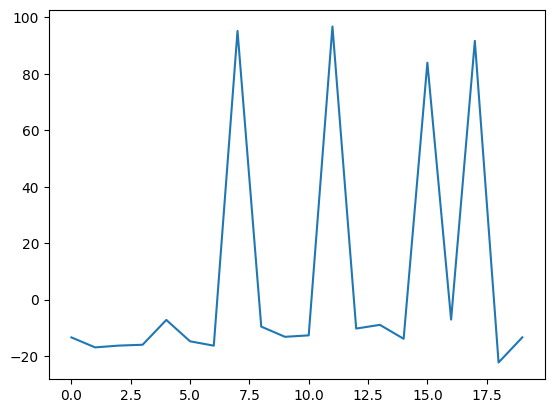

In [54]:
ENV_NAME = 'MountainCarContinuous-v0'
env = gym.make(ENV_NAME)

# 비디오 레코딩
env = RecordVideo(env, './train', episode_trigger =lambda episode_number: True )


# MountainCar 환경의 상태와 행동 크기 정의
state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]
max_action = env.action_space.high[0]


# agent 정의
# gamma, batch size, tau 정의해주기
agent = AgentDDPG2(state_size, action_size, max_action)


# 결과 그래프
def result_graph(save_epi_score):
    plt.plot(save_epi_score)
    plt.show()


## default
success = 0
height_max = -0.4

agent.update_target_network(1.0)

num_episode = 20


for ep in range(num_episode):
      # reset episode
    step, time, episode_score, done = 0 ,0, 0, False

    # 초기 noise 설정
    pre_noise = np.zeros(agent.action_size)

    # 환경 reset을 통해 초기 상태 정의
    state = env.reset()

    while not done:
        action , noise = agent.get_action(state, pre_noise) ## actor network로 action 생성 // 다음 step 때 pre_noise를 여기서 생성된 noise로 사용

        # observe reward, new_state
        next_state, reward, done, _ = env.step(action)

        # score
        episode_score += reward


        ## 보상설계
        car_xposition = next_state[0]
        car_vel = next_state[1]

        # reward1 (오래걸릴수록 - & 최대한 많이 움직이도록 velocity절대값)
        reward = float(- step/500 + abs(car_vel)/500)


        # reward2 (차의 x축 기반 높이를 구하는 2차함수 활용)
        # if car_vel > 0:
        #     reward = float(((car_xposition-0.5)*2)**2+15*car_vel - step/300)
        # else:
        #     reward = float(((car_xposition-0.5)*2)**2 - step/300)

        ### max position
        if car_xposition > height_max:
            height_max = car_xposition

        ## 성공 시 success
        if car_xposition >=  0.45:
            reward+=100
            success += 1

        step+=1

        # 플레이 버퍼에 축적
        agent.remember(state, action, reward, next_state, done)
        train_reward= reward


        # buffer 크기가 일정 기준 이상 쌓이면 학습 진행
        if len(agent.buffer) >= agent.buffer_begin :
            agent.train_model()


        # update current state
        pre_noise = noise
        state = next_state
        time += 1

    ## display rewards every episode
    print(f'Episode: {ep+1}, Success: {success}, Try: {time}, Reward: {episode_score :.2f}, height_max: {height_max :.2f}')

    agent.save_epi_score.append(episode_score)

    ## 가중치 저장
    #print('Now save')
    save_path = './save_weights'

    try:
        os.makedirs(f'{save_path}/critic')
        os.makedirs(f'{save_path}/actor')
        print("make folder")
    except:
        pass



    agent.actor.save_weights(f"{save_path}/actor/mountain_car_r12.h5")
    agent.critic.save_weights(f"{save_path}/critic/mountain_car_r12.h5")


np.savetxt('./save_weights/mountain_car_epi_reward12.txt', agent.save_epi_score)
print(agent.save_epi_score)


result_graph(agent.save_epi_score)

In [55]:
### 학습된 agent 영상 확인
### nan이 젤 큰값이므로 이값을제거하고 계산함
episode=np.argmax(agent.save_epi_score)
# episode=4
filename = 'rl-video-episode-{}.mp4'.format(episode)
print("최대 avg : {} ,에피소드 번호 : {}".format(max(agent.save_epi_score) , episode))
show_video(filename=filename)

최대 avg : 96.76521703867806 ,에피소드 번호 : 11
train/rl-video-episode-11.mp4


Episode: 1, Success: 0, Try: 999, Reward: -10.37, height_max: -0.11
Episode: 2, Success: 0, Try: 999, Reward: -16.78, height_max: 0.04
Episode: 3, Success: 0, Try: 999, Reward: -9.76, height_max: 0.08
Episode: 4, Success: 0, Try: 999, Reward: -9.90, height_max: 0.08
Episode: 5, Success: 0, Try: 999, Reward: -7.77, height_max: 0.08
Episode: 6, Success: 1, Try: 578, Reward: 91.21, height_max: 0.46
Episode: 7, Success: 1, Try: 999, Reward: -13.91, height_max: 0.46
Episode: 8, Success: 1, Try: 999, Reward: -17.29, height_max: 0.46
Episode: 9, Success: 1, Try: 999, Reward: -6.87, height_max: 0.46
Episode: 10, Success: 1, Try: 999, Reward: -10.19, height_max: 0.46
Episode: 11, Success: 1, Try: 999, Reward: -12.46, height_max: 0.46
Episode: 12, Success: 1, Try: 999, Reward: -15.75, height_max: 0.46
Episode: 13, Success: 1, Try: 999, Reward: -19.67, height_max: 0.46
Episode: 14, Success: 1, Try: 999, Reward: -12.62, height_max: 0.46
Episode: 15, Success: 1, Try: 999, Reward: -7.86, height_max:

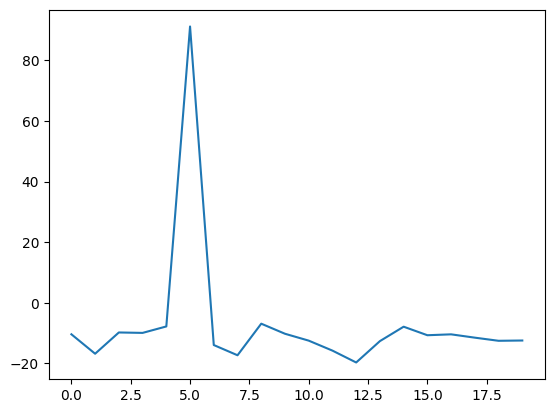

In [57]:
ENV_NAME = 'MountainCarContinuous-v0'
env = gym.make(ENV_NAME)

# 비디오 레코딩
env = RecordVideo(env, './train', episode_trigger =lambda episode_number: True )


# MountainCar 환경의 상태와 행동 크기 정의
state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]
max_action = env.action_space.high[0]


# agent 정의
# gamma, batch size, tau 정의해주기
agent = AgentDDPG(state_size, action_size, max_action)


# 결과 그래프
def result_graph(save_epi_score):
    plt.plot(save_epi_score)
    plt.show()


## default
success = 0
height_max = -0.4

agent.update_target_network(1.0)

num_episode = 20


for ep in range(num_episode):
      # reset episode
    step, time, episode_score, done = 0 ,0, 0, False

    # 초기 noise 설정
    pre_noise = np.zeros(agent.action_size)

    # 환경 reset을 통해 초기 상태 정의
    state = env.reset()

    while not done:
        action , noise = agent.get_action(state, pre_noise) ## actor network로 action 생성 // 다음 step 때 pre_noise를 여기서 생성된 noise로 사용

        # observe reward, new_state
        next_state, reward, done, _ = env.step(action)

        # score
        episode_score += reward


        ## 보상설계
        car_xposition = next_state[0]
        car_vel = next_state[1]

        # reward1 (오래걸릴수록 - & 최대한 많이 움직이도록 velocity절대값)
        # reward = float(- step/500 + abs(car_vel)/500)



        if car_vel > 0:
            reward = float(((car_xposition-0.5))**2 * car_vel - step/300)
        else:
            reward = float(((car_xposition-0.5))**2 - step/300)

        ### max position
        if car_xposition > height_max:
            height_max = car_xposition

        ## 성공 시 success
        if car_xposition >=  0.45:
            reward+=100
            success += 1

        step+=1

        # 플레이 버퍼에 축적
        agent.remember(state, action, reward, next_state, done)
        train_reward= reward


        # buffer 크기가 일정 기준 이상 쌓이면 학습 진행
        if len(agent.buffer) >= agent.buffer_begin :
            agent.train_model()


        # update current state
        pre_noise = noise
        state = next_state
        time += 1

    ## display rewards every episode
    print(f'Episode: {ep+1}, Success: {success}, Try: {time}, Reward: {episode_score :.2f}, height_max: {height_max :.2f}')

    agent.save_epi_score.append(episode_score)

    ## 가중치 저장
    #print('Now save')
    save_path = './save_weights'

    try:
        os.makedirs(f'{save_path}/critic')
        os.makedirs(f'{save_path}/actor')
        print("make folder")
    except:
        pass



    agent.actor.save_weights(f"{save_path}/actor/mountain_car_r2.h5")
    agent.critic.save_weights(f"{save_path}/critic/mountain_car_r2.h5")


np.savetxt('./save_weights/mountain_car_epi_reward2.txt', agent.save_epi_score)
print(agent.save_epi_score)


result_graph(agent.save_epi_score)

In [58]:
### 학습된 agent 영상 확인
### nan이 젤 큰값이므로 이값을제거하고 계산함
episode=np.argmax(agent.save_epi_score)
# episode=4
filename = 'rl-video-episode-{}.mp4'.format(episode)
print("최대 avg : {} ,에피소드 번호 : {}".format(max(agent.save_epi_score) , episode))
show_video(filename=filename)

최대 avg : 91.21423302665399 ,에피소드 번호 : 5
train/rl-video-episode-5.mp4
